In [1]:
##### import pandas as pd
import yfinance as yf
def fetch_stock_info(ticker, p, bar_size):
    ticker_data = yf.Ticker(ticker)
    data = ticker_data.history(period=p, interval=bar_size)
    data.reset_index(inplace=True)
    data.rename(columns={'Date': 'Datetime'}, inplace=True)
    data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
    return data

# # Example of fetch data
#1. fetch from api 
# data = fetch_stock_info('AAPL', '1y','1d')
#2. fetch from local
# df = pd.read_csv('stock_data.csv',index_col=None)
# df

In [2]:
import pandas as pd
from datetime import datetime, time
import time as tm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
class StockData:
    def __init__(self, dataframe = None, strategy_instance = None):
        self.dataframe = dataframe
        self.strategy = strategy_instance
        self.signals = None
            
    default_symbols = [
    'ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI',
    'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG',
    'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG',
    'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH',
    'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN',
    'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL',
    'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX',
    'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD',
    'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO',
    'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS'
]
    def execute_strategy(self):
        self.signals = self.strategy.execute_strategy()
    def display_head(self, n=5):
        return self.dataframe.head(n)
    def bar_generator(self, data=None, bar_length='5min'):
        # If no data argument is provided, use self.dataframe
        if data is None:
            data = self.dataframe

        # Initialize variables
        Dt = []
        Open = []
        High = []
        Low = []
        Close = []
        Volume = []
        isNewBar = []  # This will track whether each bar is new
        last_bar_index = -1  # Index of the last bar

        # Process each row in the data
        for index, row in data.iterrows():
            # Convert the datetime string to a datetime object
            current_time = pd.to_datetime(row['Datetime'])
            current_open = row['Open']
            current_high = row['High']
            current_low = row['Low']
            current_close = row['Close']
            current_volume = row['Volume']

            # Check if we are in a new bar based on the bar_length
            if last_bar_index == -1 or current_time >= Dt[last_bar_index] + pd.Timedelta(bar_length):
                # This is a new bar
                isNewBar.append(True)
                Dt.append(current_time)
                Open.append(current_open)
                High.append(current_high)
                Low.append(current_low)
                Close.append(current_close)
                Volume.append(current_volume)
                last_bar_index += 1  # Update the index of the last bar
            else:
                # We are still in the same bar, update the high, low, close, and volume
                High[last_bar_index] = max(High[last_bar_index], current_high)
                Low[last_bar_index] = min(Low[last_bar_index], current_low)
                Close[last_bar_index] = current_close
                Volume[last_bar_index] += current_volume  # Accumulate volume

        # Create and return a new DataFrame with the bars
        bar_data = pd.DataFrame({
            'Datetime': Dt,
            'Open': Open,
            'High': High,
            'Low': Low,
            'Close': Close,
            'Volume': Volume,
            'isNewBar': isNewBar
        })
        bar_data = bar_data.reset_index(drop=True)
        return bar_data
    @staticmethod
    def get_minute_data(ticker, p='1d'):
        """
        Fetches minute-level historical data for the given ticker symbol.

        :param ticker: Ticker symbol string.
        :return: DataFrame with minute-level historical data.
        """
        ticker_data = yf.Ticker(ticker)
        minute_data = ticker_data.history(period=p, interval='1m')
        minute_data.reset_index(inplace=True)
        return minute_data
    @staticmethod
    def save_data_to_local(ticker, data):
        filename = f"./stock_info/{ticker}_data.csv"
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
        
    @staticmethod
    def save_data_to_local_bar(ticker, data):
        filename = f"./stock_info/{ticker}_bar_data.csv"
        data.to_csv(filename, index=False)
        print(f"Saved data for {ticker} to {filename}")
    def get_tick_bar(self, specific_tickers=None): 
        tickers = specific_tickers if specific_tickers else self.default_symbols
        for symbol in tickers:
            try:
                # Fetch minute-level data for the symbol
                minute_data = self.get_minute_data(symbol)
                
                # Generate 5-minute bars from the minute-level data
                bar_data = self.bar_generator(minute_data)
                
                # Save the 5-minute bar data to local CSV
                self.save_data_to_local_bar(symbol, bar_data)
                
            except Exception as e:
                print(f"Failed to get data for {symbol}: {e}")

    def get_history_data_from_local_machine(self, ticker):
        filename = f"./stock_info/{ticker}_data.csv"
        filepath = os.path.join('path_to_data_directory', filename)
        if os.path.exists(filepath):
            data = pd.read_csv(filepath)
            return data
        else:
            raise FileNotFoundError(f"No historical data file found for {ticker}.")
        
    def plot_kline(self,bar_length='1d', start_time=None, end_time=None, save_path=None):
        # 使用 bar_generator 生成 bar_data
        bar_data = self.bar_generator(bar_length=bar_length) 
        # 筛选时间范围内的数据
        if start_time is not None:
            bar_data = bar_data[bar_data['Datetime'] >= start_time]
        if end_time is not None:
            bar_data = bar_data[bar_data['Datetime'] <= end_time]

        fig = go.Figure(data=[go.Candlestick(x=bar_data['Datetime'],
                                            open=bar_data['Open'],
                                             high=bar_data['High'],
                                             low=bar_data['Low'],
                                             close=bar_data['Close'],
                                             increasing_line_color='green',  # 上涨K线颜色
                                             decreasing_line_color='red'  # 下跌K线颜色
                                             )])

        fig.update_layout(title='Stock K-Line',
                          xaxis_title='Time',
                          yaxis_title='Price',
                          xaxis_rangeslider_visible=False,  # 不显示范围滑块
                          plot_bgcolor='white',  # 绘图区域背景色
                          yaxis=dict(fixedrange=True, autorange=True),  # 固定y轴范围和自动调整
                          xaxis=dict(type='category'),  # x轴类型为分类
                          hovermode='x',  # 鼠标悬停模式为x轴
                          )
        fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
        fig.show()
    def plot_kline_with_signals(self,bar_length='1d', start_time=None, end_time=None, save_path=None):
        # 使用 bar_generator 生成 bar_data
        bar_data = self.bar_generator(bar_length=bar_length) 
        # 筛选时间范围内的数据
        if start_time is not None:
            bar_data = bar_data[bar_data['Datetime'] >= start_time]
        if end_time is not None:
            bar_data = bar_data[bar_data['Datetime'] <= end_time]

        fig = go.Figure(data=[go.Candlestick(x=bar_data['Datetime'],
                                            open=bar_data['Open'],
                                             high=bar_data['High'],
                                             low=bar_data['Low'],
                                             close=bar_data['Close'],
                                             increasing_line_color='green',  # 上涨K线颜色
                                             decreasing_line_color='red'  # 下跌K线颜色
                                             )])

        fig.update_layout(title='Stock K-Line',
                          xaxis_title='Time',
                          yaxis_title='Price',
                          xaxis_rangeslider_visible=False,  # 不显示范围滑块
                          plot_bgcolor='white',  # 绘图区域背景色
                          yaxis=dict(fixedrange=True, autorange=True),  # 固定y轴范围和自动调整
                          xaxis=dict(type='category'),  # x轴类型为分类
                          hovermode='x',  # 鼠标悬停模式为x轴
                          )
        if hasattr(self.strategy, 'buy_signals'):
            buy_timestamps = [signal['timestamp'] for signal in self.strategy.buy_signals]
            buy_prices = [signal['price'] for signal in self.strategy.buy_signals]

            fig.add_trace(go.Scatter(
                x=buy_timestamps,
                y=buy_prices,
                mode='markers',
                name='buy signal',
                marker=dict(color='green', size=10, symbol='triangle-up'),
                showlegend=True
            ))

    # 添加卖出信号点
        if hasattr(self.strategy, 'sell_signals'):
            sell_timestamps = [signal['timestamp'] for signal in self.strategy.sell_signals]
            sell_prices = [signal['price'] for signal in self.strategy.sell_signals]

            fig.add_trace(go.Scatter(
                x=sell_timestamps,
                y=sell_prices,
                mode='markers',
                name='Sell signal',
                marker=dict(color='red', size=10, symbol='triangle-down'),
                showlegend=True
            ))

        # 连接对应的买入和卖出信号点
        for buy_signal, sell_signal in zip(self.strategy.buy_signals, self.strategy.sell_signals):
            fig.add_trace(go.Scatter(
                x=[buy_signal['timestamp'], sell_signal['timestamp']],
                y=[buy_signal['price'], sell_signal['price']],
                mode='lines',
                line=dict(color='grey', width=1),
                showlegend=False
            ))
#         if hasattr(self, 'buy_signals'):
#             for signal in self.strategy.buy_signals:
#                 print(signal)
# #                 fig.add_trace(go.Scatter(x=[signal['timestamp']], y=[signal['price']],
# #                                          mode='markers', name='Buy Signal',
# #                                          marker=dict(color='black'), showlegend=False))

# #         # 添加卖出信号点并将其与相应的买入信号连接
# #         if hasattr(self, 'sell_signals'):
# #             for i, signal in enumerate(self.strategy.sell_signals):
# #                 fig.add_trace(go.Scatter(x=[signal['timestamp']], y=[signal['price']],
# #                                          mode='markers', name='Sell Signal' if i == 0 else '',
# #                                          marker=dict(color='blue'), showlegend=i == 0))
# #                 # 连接买入点和卖出点
# #                 if i < len(self.strategy.buy_signals):
# #                     fig.add_trace(go.Scatter(x=[self.strategy.buy_signals[i]['timestamp'], signal['timestamp']],
# #                                              y=[self.strategy.buy_signals[i]['price'], signal['price']],
# #                                              mode='lines', line=dict(color='grey'), showlegend=False))

#         # 设置图例
        fig.update_layout(legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01))
        fig.show()
    def print_order_stats(self):
        win_rate,total_pnl = self.strategy.print_order_stats()
        return win_rate,total_pnl
# Usage:
#df = pd.read_csv('stock_data.csv')
#stock_data_ma = StockData(df,"ma")#实例化
#stock_data_ma.get_history_data_from_local_machine() 还没完成
#print(stock_data.display_head())
#bar_data = stock_data_ma.bar_generator()
#stock_data_ma.print_contents()
#stock_data_ma.strategy(bar_data)
#stock_data_ma.analyze_stock_data('2015-01-15','2015-07-20')
#stock_data_ma.print_order_stats()
#while time(9,26)<datetime.now().time()<time(11,32) or time(13)<datetime.now().time()<time(15,2):
#print(bars.head())
#stock_data_ma.strategy()

In [3]:
import pandas as pd

class Strategy:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.current_order = {}
        self.order_number = 0
        self.total_pnl = 0
        self.buy_signals = []
        self.sell_signals = []
        self.historical_orders = []

    def buy(self, open_price, open_datetime, volume):
        self.order_number += 1
        order_id = f'order{self.order_number}'
        self.current_order[order_id] = {'open_price': open_price, 'open_datetime': open_datetime, 'volume': volume}
        print(f"Buy order {order_id} executed at {open_price} for volume {volume} on {open_datetime}")
        self.buy_signals.append({'timestamp': open_datetime, 'price': open_price})

    def sell(self, close_price, close_datetime, volume):
        stamp_duty_rate = 0.001
        for order_id, order_info in list(self.current_order.items()):
            if volume <= order_info['volume']:
                sell_volume = volume
                order_info['volume'] -= volume

                stamp_duty = close_price * sell_volume * stamp_duty_rate
                order_pnl = (close_price - order_info['open_price']) * sell_volume - stamp_duty
                order_info['pnl'] = order_pnl
                self.total_pnl += order_pnl

                sell_order_info = order_info.copy()
                sell_order_info['close_price'] = close_price
                sell_order_info['close_datetime'] = close_datetime
                sell_order_info['volume'] = sell_volume
                sell_order_info['stamp_duty'] = stamp_duty
                sell_order_info['pnl'] = order_pnl
                self.historical_orders.append(sell_order_info)
                self.sell_signals.append({'timestamp': close_datetime, 'price': close_price, 'stamp_duty': stamp_duty, 'pnl': order_pnl})

                if order_info['volume'] == 0:
                    self.current_order.pop(order_id)

                print(f"Sell order {order_id} executed at {close_price} for volume {sell_volume} on {close_datetime}, stamp duty: {stamp_duty}, PnL: {order_pnl}")
            else:
                print("Sell volume is greater than the current order volume")

    def execute_strategy(self):
        raise NotImplementedError("The execute_strategy method should be implemented by the subclass")
    def print_order_stats(self):
        profit_count = 0
        loss_count = 0
        total_pnl = 0  # 初始化总盈亏为0
        total_orders = len(self.historical_orders)  # 总订单数

        # 遍历历史订单列表
        for order in self.historical_orders:
            if 'pnl' in order:
                total_pnl += order['pnl']
                if order['pnl'] > 0:
                    profit_count += 1  # 如果订单盈利，盈利计数器加1
                elif order['pnl'] < 0:
                    loss_count += 1  # 如果订单亏损，亏损计数器加1
                # 如果 pnl 等于 0，可以选择忽略或者单独计数

        # 计算胜率和失败率
        win_rate = profit_count / total_orders if total_orders else 0
        loss_rate = loss_count / total_orders if total_orders else 0

        # 直接打印统计数据
        print(f"Total number of orders: {total_orders}")
        print(f"Number of profitable orders: {profit_count}, Number of unprofitable orders: {loss_count}")
        print(f"Win rate: {win_rate:.2%}, Loss rate: {loss_rate:.2%}")
        print(f"Total PnL: {total_pnl}$")  # 打印总盈亏
        return win_rate,total_pnl

In [4]:
import pandas as pd

class SimpleMAStrategy(Strategy):
    def __init__(self, dataframe):
        super().__init__(dataframe)
        self.calculate_ma20()  # Calculate MA20

    def calculate_ma20(self):
        self.dataframe['MA20'] = self.dataframe['Close'].rolling(window=20).mean()

    def execute_strategy(self):
        # Assuming the dataframe has a 'Datetime' column in string format that we convert to datetime
        if not pd.api.types.is_datetime64_any_dtype(self.dataframe['Datetime']):
            self.dataframe['Datetime'] = pd.to_datetime(self.dataframe['Datetime'])

        initial_volume = 100

        for _, row in self.dataframe.iterrows():
            current_close = row['Close']
            ma20_value = row['MA20']
            current_time = row['Datetime']  # 使用行数据直接获取Datetime值

            if pd.isnull(ma20_value):
                continue  # Skip if MA20 is NaN

            if current_close < ma20_value * 0.95 and not self.current_order:
                # If the price is below 95% of MA20 and there are no open orders, BUY
                self.buy(current_close + 0.01, current_time, initial_volume)

            elif current_close > ma20_value * 1.05 and self.current_order:
                # If the price is above 105% of MA20 and there are open orders, SELL
                sell_volume = sum(order['volume'] for order in self.current_order.values())
                self.sell(current_close - 0.01, current_time, sell_volume)
# Example usage:
# Load your historical data into a DataFrame 'df' with columns: 'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume'
# df = pd.read_csv('stock_data.csv')

# # Initialize the strategy with the dataframe
# simple_ma_strategy = SimpleMAStrategy(df)

# # Execute the strategy
# simple_ma_strategy.execute_strategy()

In [5]:
class DualMovingAverageStrategy(Strategy):
    def __init__(self, dataframe, short_window=20, long_window=50):
        super().__init__(dataframe)
        self.short_window = short_window
        self.long_window = long_window
        self.signals = pd.DataFrame()
        self.generate_signals()

    def generate_signals(self):
        # 创建短期和长期的简单移动平均线
        self.signals['Short_MA'] = self.dataframe['Close'].rolling(window=self.short_window, min_periods=1).mean()
        self.signals['Long_MA'] = self.dataframe['Close'].rolling(window=self.long_window, min_periods=1).mean()
        
        # 创建信号
        self.signals['Signal'] = 0.0
        # 短期均线上穿长期均线时买入信号
        self.signals['Signal'][self.short_window:] = np.where(self.signals['Short_MA'][self.short_window:] 
                                                              > self.signals['Long_MA'][self.short_window:], 1.0, 0.0)
        # 产生交易指令
        self.signals['Positions'] = self.signals['Signal'].diff()

    def execute_strategy(self):
        for index, row in self.dataframe.iterrows():
            current_time = row['Datetime']
            if self.signals.loc[index, 'Positions'] == 1.0:
                # Buy logic
                if not self.current_order:
                    self.buy(row['Close'] + 0.01, current_time, 100)  # Placeholder for volume, adjust as needed

            elif self.signals.loc[index, 'Positions'] == -1.0:
                # Sell logic, assuming we sell all
                if self.current_order:
                    sell_volume = sum(order['volume'] for order in self.current_order.values())
                    self.sell(row['Close'] - 0.01, current_time, sell_volume)

In [6]:
class TurtleStrategy(Strategy):
    def __init__(self, dataframe, entry_breakout_period=20, exit_breakout_period=10, atr_period=14):
        super().__init__(dataframe)
        self.entry_breakout_period = entry_breakout_period
        self.exit_breakout_period = exit_breakout_period
        self.atr_period = atr_period
        self.signals = pd.DataFrame()
        self.generate_signals()

    def generate_donchian_channel(self):
        self.signals['High20'] = self.dataframe['High'].rolling(window=self.entry_breakout_period, min_periods=1).max()
        self.signals['Low20'] = self.dataframe['Low'].rolling(window=self.entry_breakout_period, min_periods=1).min()
        self.signals['High10'] = self.dataframe['High'].rolling(window=self.exit_breakout_period, min_periods=1).max()
        self.signals['Low10'] = self.dataframe['Low'].rolling(window=self.exit_breakout_period, min_periods=1).min()

    def calculate_atr(self):
        h_l = abs(self.dataframe['High'] - self.dataframe['Low'])
        h_pc = abs(self.dataframe['High'] - self.dataframe['Close'].shift(1))
        l_pc = abs(self.dataframe['Low'] - self.dataframe['Close'].shift(1))
        tr = pd.DataFrame({'H-L': h_l, 'H-PC': h_pc, 'L-PC': l_pc}).max(axis=1)
        self.signals['ATR'] = tr.rolling(window=self.atr_period, min_periods=1).mean()

    def generate_signals(self):
        self.generate_donchian_channel()
        self.calculate_atr()

        self.signals['Buy'] = (self.dataframe['Close'] > self.signals['High20'].shift(1))
        self.signals['Sell'] = (self.dataframe['Close'] < self.signals['Low10'].shift(1))

    def execute_strategy(self):
        for index, row in self.dataframe.iterrows():
            current_time = row['Datetime']
            if self.signals.loc[index, 'Buy'] and not self.current_order:
                # Buy logic
                self.buy(row['Close']+0.01, current_time, 100)  # Placeholder for volume, adjust as needed

            elif self.signals.loc[index, 'Sell'] and self.current_order:
                # Sell logic, assuming we sell all
                sell_volume = sum(order['volume'] for order in self.current_order.values())
                self.sell(row['Close']- 0.01, current_time, sell_volume)

# Example usage:
# Assuming the dataframe is already loaded with the stock data and includes the mentioned columns
# dataframe = pd.read_csv('stock_data.csv')
# turtle_strategy = TurtleStrategy(dataframe)
# turtle_strategy.execute_strategy()
# Now, the TurtleStrategy will print buy/sell execution messages with prices and timestamps

In [7]:
# #df = pd.read_csv('stock_data.csv',index_col=None)
# simple_ma_strategy = DualMovingAverageStrategy(data)
# # 2. Initialize StockData with the strategy
# stock_data = StockData(data, simple_ma_strategy)

# # 3. Execute the strategy
# stock_data.execute_strategy()
# # 4.show the trading process (buy and sell)
# stock_data.plot_kline_with_signals('1d')
# stock_data.print_order_stats()

In [ ]:
import os
def main_menu():
    while True:
        print("\nQuant Trading System Menu:")
        print("1. Fetch Stock Information")
        print("2. Select Strategy")
        print("3. Run Backtest")
        print("4. Exit")
        
        choice = input("Please choose an option (1/2/3): ")
        
        if choice == '1':
            stock_code = input("Enter the stock code: ")
            period = input("Enter the period (e.g., 1d for one day, 5mo for five mouth,1y for 1 year): ")
            bar_size = input("Enter the bar length(means the period length of each data unit) (e.g., 1d for one day, 1h for one hour, 5m for five minutes): ")
            data = fetch_stock_info(stock_code, period, bar_size)
            stock_data = StockData(data)
            print("1. Show data")
            print("2. Exit")
            choice_diaplay = input("Please choose an option (1/2/): ")
            
            if choice_diaplay == '1':
                stock_data.plot_kline('1d')
            elif choice_diaplay == '2':
                print("Exiting the Quant Trading System.")
                break
            else:
                print("Invalid option, please try again!")
        elif choice == '2':
            print("\nStrategy Menu:")
            print("1. 20-day Simple Moving Average Strategy")
            print("2. Dual Moving Average Crossover Strategy")
            print("3. Turtle Strategy")
            print("4. Exit")
            print("Please select strategy(1/2/3/4):")
            choice_strategy= input("Please choose an option (1/2/3/4): ")
            if choice_strategy == '1':
                simple_ma_strategy = SimpleMAStrategy(data)
                stock_data = StockData(data, simple_ma_strategy)
            elif choice_strategy == '2':
                dual_moving_average_strategy = DualMovingAverageStrategy(data)
                stock_data = StockData(data, dual_moving_average_strategy)
            elif choice_strategy == '3':
                turtle_strategy = TurtleStrategy(data)
                stock_data = StockData(data, turtle_strategy)
            elif choice_strategy == '4':
                break
            else:
                print("Invalid option, please try again!")
            stock_data.execute_strategy()
            stock_data.plot_kline_with_signals('1d')
            stock_data.print_order_stats()
        elif choice == '3':
            print("Backtest.")
            stock_code = input("Enter the stock code: ")
            period = input("Enter the period (e.g., 1d for one day, 5mo for five mouth,1y for 1 year): ")
            bar_size = input("Enter the bar length (e.g., 1d for one day, 1h for one hour, 5m for five minutes): ")
            data = fetch_stock_info(stock_code, period, bar_size)
            stock_data_ma = StockData(data)
            stock_data_ma.analyze_stock_data(start_date,end_date,bar_size)
        elif choice == '4':
            print("Exiting the Quant Trading System.")
            break
        else:
            print("Invalid option, please try again!")

if __name__ == "__main__":
    main_menu()


Quant Trading System Menu:
1. Fetch Stock Information
2. Select Strategy
3. Run Backtest
4. Exit
Please choose an option (1/2/3): 1
Enter the stock code: aapl
Enter the period (e.g., 1d for one day, 5mo for five mouth,1y for 1 year): 1y
Enter the bar length(means the period length of each data unit) (e.g., 1d for one day, 1h for one hour, 5m for five minutes): 1d
1. Show data
2. Exit
Please choose an option (1/2/): 1



Quant Trading System Menu:
1. Fetch Stock Information
2. Select Strategy
3. Run Backtest
4. Exit
Please choose an option (1/2/3): 2

Strategy Menu:
1. 20-day Simple Moving Average Strategy
2. Dual Moving Average Crossover Strategy
3. Turtle Strategy
4. Exit
Please select strategy(1/2/3/4):
Please choose an option (1/2/3/4): 1
Buy order order1 executed at 181.28413940429687 for volume 100 on 2023-08-04 00:00:00-04:00
Sell order order1 executed at 188.95958923339845 for volume 100 on 2023-09-01 00:00:00-04:00, stamp duty: 18.895958923339844, PnL: 748.6490239868182
Buy order order2 executed at 181.6881768798828 for volume 100 on 2024-01-04 00:00:00-05:00


Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 748.6490239868182$

Quant Trading System Menu:
1. Fetch Stock Information
2. Select Strategy
3. Run Backtest
4. Exit
Please choose an option (1/2/3): 2

Strategy Menu:
1. 20-day Simple Moving Average Strategy
2. Dual Moving Average Crossover Strategy
3. Turtle Strategy
4. Exit
Please select strategy(1/2/3/4):
Please choose an option (1/2/3/4): 3
Buy order order1 executed at 164.69099975585937 for volume 100 on 2023-04-13 00:00:00-04:00
Sell order order1 executed at 190.40802978515626 for volume 100 on 2023-08-03 00:00:00-04:00, stamp duty: 19.040802978515625, PnL: 2552.6621999511735
Buy order order2 executed at 188.97958923339843 for volume 100 on 2023-09-01 00:00:00-04:00
Sell order order2 executed at 171.504892578125 for volume 100 on 2023-09-26 00:00:00-04:00, stamp duty: 17.1504892578125, PnL: -1764.6201547851545
Buy order order3 executed at 179.

Total number of orders: 4
Number of profitable orders: 2, Number of unprofitable orders: 2
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: 356.73365850830794$

Quant Trading System Menu:
1. Fetch Stock Information
2. Select Strategy
3. Run Backtest
4. Exit
Please choose an option (1/2/3): 2

Strategy Menu:
1. 20-day Simple Moving Average Strategy
2. Dual Moving Average Crossover Strategy
3. Turtle Strategy
4. Exit
Please select strategy(1/2/3/4):
Please choose an option (1/2/3/4): 2
Buy order order1 executed at 170.8680322265625 for volume 100 on 2023-05-09 00:00:00-04:00
Sell order order1 executed at 176.1029608154297 for volume 100 on 2023-08-16 00:00:00-04:00, stamp duty: 17.61029608154297, PnL: 505.8825628051776
Buy order order2 executed at 187.2111260986328 for volume 100 on 2023-11-14 00:00:00-05:00
Sell order order2 executed at 182.4371893310547 for volume 100 on 2024-01-17 00:00:00-05:00, stamp duty: 18.24371893310547, PnL: -495.63739569091615


Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: 10.245167114261449$

Quant Trading System Menu:
1. Fetch Stock Information
2. Select Strategy
3. Run Backtest
4. Exit


In [9]:
 default_symbols = [
    'ADBE', 'ADP', 'ABNB', 'GOOGL', 'GOOG', 'AMZN', 'AMD', 'AEP', 'AMGN', 'ADI',
    'ANSS', 'AAPL', 'AMAT', 'ASML', 'AZN', 'TEAM', 'ADSK', 'BKR', 'BIIB', 'BKNG',
    'AVGO', 'CDNS', 'CDW', 'CHTR', 'CTAS', 'CSCO', 'CCEP', 'CTSH', 'CMCSA', 'CEG',
    'CPRT', 'CSGP', 'COST', 'CRWD', 'CSX', 'DDOG', 'DXCM', 'FANG', 'DLTR', 'DASH',
    'EA', 'EXC', 'FAST', 'FTNT', 'GEHC', 'GILD', 'GFS', 'HON', 'IDXX', 'ILMN',
    'INTC', 'INTU', 'ISRG', 'KDP', 'KLAC', 'KHC', 'LRCX', 'LULU', 'MAR', 'MRVL',
    'MELI', 'META', 'MCHP', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MDB', 'MNST', 'NFLX',
    'NVDA', 'NXPI', 'ORLY', 'ODFL', 'ON', 'PCAR', 'PANW', 'PAYX', 'PYPL', 'PDD',
    'PEP', 'QCOM', 'REGN', 'ROP', 'ROST', 'SIRI', 'SPLK', 'SBUX', 'SNPS', 'TTWO',
    'TMUS', 'TSLA', 'TXN', 'TTD', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS'
]

In [10]:
period = '1y'
bar_size = '1d'

# Create a dictionary to store the data
stock_data = {}

strategy_results = {}

# 遍历每个股票代码
for symbol in default_symbols:
    print(f"Fetching data for {symbol}")
    data = fetch_stock_info(symbol, period, bar_size)
    
    # 检查数据是否为空
    if data.empty:
        print(f"No data for {symbol}, skipping.")
        continue
    
    # 简单移动平均策略
    simple_ma_strategy = SimpleMAStrategy(data)
    stock_data = StockData(data, simple_ma_strategy)
    stock_data.execute_strategy()
    win_rate1, total_pnl1 = stock_data.print_order_stats()
    # 双重移动平均策略
    dual_moving_average_strategy = DualMovingAverageStrategy(data)
    stock_data = StockData(data, dual_moving_average_strategy)
    stock_data.execute_strategy()
    win_rate2,total_pnl2  = stock_data.print_order_stats()
    # 海龟交易策略
    turtle_strategy = TurtleStrategy(data)
    stock_data = StockData(data, turtle_strategy)
    stock_data.execute_strategy()
    win_rate3,total_pnl3  = stock_data.print_order_stats()
    
    strategy_results[symbol] = {
        'Simple_MA': {'win_rate': win_rate1, 'total_pnl': total_pnl1},
        'Dual_MA': {'win_rate': win_rate2, 'total_pnl': total_pnl2},
        'Turtle': {'win_rate': win_rate3, 'total_pnl': total_pnl3}
    }



Fetching data for ADBE
Buy order order1 executed at 345.26 for volume 100 on 2023-05-03 00:00:00-04:00
Sell order order1 executed at 392.04999755859376 for volume 100 on 2023-05-25 00:00:00-04:00, stamp duty: 39.204999755859376, PnL: 4639.794756103517
Buy order order2 executed at 513.8900048828125 for volume 100 on 2023-09-21 00:00:00-04:00
Sell order order2 executed at 549.8999731445313 for volume 100 on 2023-10-11 00:00:00-04:00, stamp duty: 54.98999731445313, PnL: 3546.006828857424
Buy order order3 executed at 508.1299951171875 for volume 100 on 2023-10-27 00:00:00-04:00
Sell order order3 executed at 585.1900122070313 for volume 100 on 2023-11-07 00:00:00-05:00, stamp duty: 58.519001220703124, PnL: 7647.482707763674
Buy order order4 executed at 567.0599877929687 for volume 100 on 2024-01-04 00:00:00-05:00
Sell order order4 executed at 622.5700170898438 for volume 100 on 2024-01-25 00:00:00-05:00, stamp duty: 62.257001708984376, PnL: 5488.745927978517
Buy order order5 executed at 546

Buy order order1 executed at 125.62000061035157 for volume 100 on 2023-10-25 00:00:00-04:00
Sell order order1 executed at 136.91999267578126 for volume 100 on 2023-11-16 00:00:00-05:00, stamp duty: 13.691999267578126, PnL: 1116.3072072753912
Buy order order2 executed at 133.36000610351562 for volume 100 on 2024-03-04 00:00:00-05:00
Sell order order2 executed at 147.66999267578126 for volume 100 on 2024-03-18 00:00:00-04:00, stamp duty: 14.766999267578125, PnL: 1416.2316579589863
Total number of orders: 2
Number of profitable orders: 2, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 2532.538865234377$
Buy order order1 executed at 103.8599984741211 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 122.01999877929687 for volume 100 on 2023-07-19 00:00:00-04:00, stamp duty: 12.201999877929687, PnL: 1803.7980306396475
Buy order order2 executed at 132.73000122070312 for volume 100 on 2023-07-31 00:00:00-04:00
Sell order order2 executed

Buy order order1 executed at 79.8245751953125 for volume 100 on 2023-05-25 00:00:00-04:00
Sell order order1 executed at 77.44614624023437 for volume 100 on 2023-11-02 00:00:00-04:00, stamp duty: 7.744614624023437, PnL: -245.58751013183695
Total number of orders: 1
Number of profitable orders: 0, Number of unprofitable orders: 1
Win rate: 0.00%, Loss rate: 100.00%
Total PnL: -245.58751013183695$
Buy order order1 executed at 90.49536682128907 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 84.22582458496093 for volume 100 on 2023-05-17 00:00:00-04:00, stamp duty: 8.422582458496095, PnL: -635.3768060913096
Buy order order2 executed at 84.75856567382813 for volume 100 on 2023-07-24 00:00:00-04:00
Sell order order2 executed at 79.27404998779296 for volume 100 on 2023-08-11 00:00:00-04:00, stamp duty: 7.927404998779296, PnL: -556.3789736022959
Buy order order3 executed at 76.53909851074219 for volume 100 on 2023-11-14 00:00:00-05:00
Sell order order3 executed at 77.

Buy order order1 executed at 181.28413940429687 for volume 100 on 2023-08-04 00:00:00-04:00
Sell order order1 executed at 188.95958923339845 for volume 100 on 2023-09-01 00:00:00-04:00, stamp duty: 18.895958923339844, PnL: 748.6490239868182
Buy order order2 executed at 181.6881768798828 for volume 100 on 2024-01-04 00:00:00-05:00
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 748.6490239868182$
Buy order order1 executed at 162.91049743652343 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 176.1029608154297 for volume 100 on 2023-08-16 00:00:00-04:00, stamp duty: 17.61029608154297, PnL: 1301.636041809084
Buy order order2 executed at 187.2111260986328 for volume 100 on 2023-11-14 00:00:00-05:00
Sell order order2 executed at 182.4371893310547 for volume 100 on 2024-01-17 00:00:00-05:00, stamp duty: 18.24371893310547, PnL: -495.63739569091615
Total number of orders: 2
Number

Buy order order1 executed at 67.92368103027344 for volume 100 on 2023-03-31 00:00:00-04:00
Sell order order1 executed at 70.82921813964843 for volume 100 on 2023-05-24 00:00:00-04:00, stamp duty: 7.082921813964843, PnL: 283.47078912353413
Buy order order2 executed at 68.2415902709961 for volume 100 on 2023-10-17 00:00:00-04:00
Sell order order2 executed at 62.08587097167969 for volume 100 on 2023-10-23 00:00:00-04:00, stamp duty: 6.208587097167969, PnL: -621.780517028809
Buy order order3 executed at 64.91274047851563 for volume 100 on 2023-12-13 00:00:00-05:00
Sell order order3 executed at 65.23744415283203 for volume 100 on 2024-01-17 00:00:00-05:00, stamp duty: 6.523744415283202, PnL: 25.946623016356398
Buy order order4 executed at 67.67999816894532 for volume 100 on 2024-03-11 00:00:00-04:00
Total number of orders: 3
Number of profitable orders: 2, Number of unprofitable orders: 1
Win rate: 66.67%, Loss rate: 33.33%
Total PnL: -312.36310488891843$
Fetching data for TEAM
Buy order or

Buy order order1 executed at 2842.97484375 for volume 100 on 2023-10-18 00:00:00-04:00
Sell order order1 executed at 3012.620615234375 for volume 100 on 2023-11-08 00:00:00-05:00, stamp duty: 301.2620615234375, PnL: 16663.31508691402
Buy order order2 executed at 3469.2521875 for volume 100 on 2024-02-27 00:00:00-05:00
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 16663.31508691402$
Buy order order1 executed at 2638.2785546875 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 2598.67994140625 for volume 100 on 2023-06-12 00:00:00-04:00, stamp duty: 259.867994140625, PnL: -4219.729322265669
Buy order order2 executed at 2693.4475 for volume 100 on 2023-06-30 00:00:00-04:00
Sell order order2 executed at 3041.64625 for volume 100 on 2023-10-06 00:00:00-04:00, stamp duty: 304.164625, PnL: 34515.71037499996
Buy order order3 executed at 3107.647451171875 for volume 100 on 2023-11

Buy order order1 executed at 323.95000244140624 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 368.69001220703126 for volume 100 on 2023-04-28 00:00:00-04:00, stamp duty: 36.869001220703126, PnL: 4437.131975341798
Buy order order2 executed at 319.67000366210937 for volume 100 on 2023-05-25 00:00:00-04:00
Sell order order2 executed at 353.82999633789063 for volume 100 on 2023-06-27 00:00:00-04:00, stamp duty: 35.38299963378906, PnL: 3380.616267944338
Buy order order3 executed at 411.7199914550781 for volume 100 on 2023-10-26 00:00:00-04:00
Total number of orders: 2
Number of profitable orders: 2, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 7817.748243286136$
Buy order order1 executed at 331.249990234375 for volume 100 on 2023-05-24 00:00:00-04:00
Sell order order1 executed at 319.6500036621094 for volume 100 on 2023-05-25 00:00:00-04:00, stamp duty: 31.965000366210937, PnL: -1191.9636575927716
Buy order order2 executed at 36

Buy order order1 executed at 38.90108657836914 for volume 100 on 2023-10-26 00:00:00-04:00
Sell order order1 executed at 44.334776153564455 for volume 100 on 2023-12-14 00:00:00-05:00, stamp duty: 4.433477615356446, PnL: 538.9354799041753
Buy order order2 executed at 41.26 for volume 100 on 2024-02-08 00:00:00-05:00
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 538.9354799041753$
Buy order order1 executed at 36.17285705566406 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 44.262842407226564 for volume 100 on 2023-09-28 00:00:00-04:00, stamp duty: 4.426284240722656, PnL: 804.5722509155278
Buy order order2 executed at 44.19583297729492 for volume 100 on 2023-12-15 00:00:00-05:00
Sell order order2 executed at 41.89000152587891 for volume 100 on 2024-02-23 00:00:00-05:00, stamp duty: 4.189000152587891, PnL: -234.77214529418904
Total number of orders: 2
Number of profitable

Total number of orders: 0
Number of profitable orders: 0, Number of unprofitable orders: 0
Win rate: 0.00%, Loss rate: 0.00%
Total PnL: 0$
Buy order order1 executed at 488.42659545898437 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 473.2589208984375 for volume 100 on 2023-05-25 00:00:00-04:00, stamp duty: 47.32589208984375, PnL: -1564.0933481445295
Buy order order2 executed at 494.17259765625 for volume 100 on 2023-05-30 00:00:00-04:00
Sell order order2 executed at 532.7620336914063 for volume 100 on 2023-09-06 00:00:00-04:00, stamp duty: 53.276203369140624, PnL: 3805.667400146486
Buy order order3 executed at 538.8924462890625 for volume 100 on 2023-09-26 00:00:00-04:00
Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: 2241.5740520019567$
Buy order order1 executed at 490.76592041015624 for volume 100 on 2023-04-20 00:00:00-04:00
Sell order order1 executed at 478.43372558

Buy order order1 executed at 122.01 for volume 100 on 2023-08-01 00:00:00-04:00
Sell order order1 executed at 89.28000091552734 for volume 100 on 2023-10-27 00:00:00-04:00, stamp duty: 8.928000091552734, PnL: -3281.9279085388193
Buy order order2 executed at 117.03999877929688 for volume 100 on 2024-02-13 00:00:00-05:00
Sell order order2 executed at 133.71000122070313 for volume 100 on 2024-03-06 00:00:00-05:00, stamp duty: 13.371000122070313, PnL: 1653.6292440185553
Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: -1628.298664520264$
Buy order order1 executed at 123.96999908447266 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 113.2599966430664 for volume 100 on 2023-08-10 00:00:00-04:00, stamp duty: 11.325999664306641, PnL: -1082.3262438049326
Buy order order2 executed at 102.12000061035157 for volume 100 on 2023-11-15 00:00:00-05:00
Sell order order2 executed at 117.040

Buy order order1 executed at 125.77830291748047 for volume 100 on 2023-08-02 00:00:00-04:00
Sell order order1 executed at 127.72208618164062 for volume 100 on 2023-10-10 00:00:00-04:00, stamp duty: 12.772208618164063, PnL: 181.60611779785054
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 181.60611779785054$
Buy order order1 executed at 128.7614190673828 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 120.1524526977539 for volume 100 on 2023-08-16 00:00:00-04:00, stamp duty: 12.015245269775392, PnL: -872.9118822326656
Buy order order2 executed at 129.3477227783203 for volume 100 on 2023-10-11 00:00:00-04:00
Sell order order2 executed at 132.9500067138672 for volume 100 on 2024-03-19 00:00:00-04:00, stamp duty: 13.295000671386719, PnL: 346.9333928833026
Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 5

Buy order order1 executed at 76.25800109863282 for volume 100 on 2023-05-09 00:00:00-04:00
Sell order order1 executed at 82.8188345336914 for volume 100 on 2023-06-06 00:00:00-04:00, stamp duty: 8.28188345336914, PnL: 647.8014600524892
Buy order order2 executed at 73.87692047119141 for volume 100 on 2023-08-08 00:00:00-04:00
Sell order order2 executed at 71.53183959960937 for volume 100 on 2023-11-03 00:00:00-04:00, stamp duty: 7.153183959960937, PnL: -241.66127111816508
Buy order order3 executed at 71.56000305175782 for volume 100 on 2024-01-24 00:00:00-05:00
Sell order order3 executed at 81.94999908447265 for volume 100 on 2024-02-06 00:00:00-05:00, stamp duty: 8.194999908447265, PnL: 1030.8046033630362
Total number of orders: 3
Number of profitable orders: 2, Number of unprofitable orders: 1
Win rate: 66.67%, Loss rate: 33.33%
Total PnL: 1436.9447922973604$
Buy order order1 executed at 80.27158142089844 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 74.790

Buy order order1 executed at 191.94702697753905 for volume 100 on 2023-07-28 00:00:00-04:00
Total number of orders: 0
Number of profitable orders: 0, Number of unprofitable orders: 0
Win rate: 0.00%, Loss rate: 0.00%
Total PnL: 0$
Buy order order1 executed at 191.69846130371093 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 184.51267456054688 for volume 100 on 2023-08-08 00:00:00-04:00, stamp duty: 18.451267456054687, PnL: -737.0299417724591
Buy order order2 executed at 177.99861694335937 for volume 100 on 2023-10-05 00:00:00-04:00
Sell order order2 executed at 181.85436462402345 for volume 100 on 2023-10-12 00:00:00-04:00, stamp duty: 18.185436462402343, PnL: 367.38933160400575
Buy order order3 executed at 191.26875854492187 for volume 100 on 2023-11-22 00:00:00-05:00
Sell order order3 executed at 191.94492553710938 for volume 100 on 2024-02-05 00:00:00-05:00, stamp duty: 19.194492553710937, PnL: 48.42220666504088
Buy order order4 executed at 196.36000610351

Buy order order1 executed at 411.65694213867187 for volume 100 on 2023-04-26 00:00:00-04:00
Sell order order1 executed at 451.84638427734376 for volume 100 on 2023-05-22 00:00:00-04:00, stamp duty: 45.18463842773438, PnL: 3973.759575439455
Buy order order2 executed at 404.08467651367187 for volume 100 on 2023-05-30 00:00:00-04:00
Sell order order2 executed at 454.0355017089844 for volume 100 on 2023-06-15 00:00:00-04:00, stamp duty: 45.40355017089844, PnL: 4949.678969360353
Buy order order3 executed at 502.7454736328125 for volume 100 on 2023-09-21 00:00:00-04:00
Sell order order3 executed at 531.3695776367188 for volume 100 on 2023-11-13 00:00:00-05:00, stamp duty: 53.13695776367187, PnL: 2809.273442626955
Total number of orders: 3
Number of profitable orders: 3, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 11732.711987426763$
Buy order order1 executed at 417.7564904785156 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 424.

Buy order order1 executed at 32.4222314453125 for volume 100 on 2023-08-16 00:00:00-04:00
Sell order order1 executed at 32.74304412841797 for volume 100 on 2023-11-02 00:00:00-04:00, stamp duty: 3.274304412841797, PnL: 28.806963897705476
Buy order order2 executed at 33.78346420288086 for volume 100 on 2024-02-14 00:00:00-05:00
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 28.806963897705476$
Buy order order1 executed at 37.705480346679686 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 36.74832748413086 for volume 100 on 2023-06-05 00:00:00-04:00, stamp duty: 3.674832748413086, PnL: -99.3901190032955
Buy order order2 executed at 33.38858963012695 for volume 100 on 2023-11-21 00:00:00-05:00
Sell order order2 executed at 33.76346420288086 for volume 100 on 2024-02-14 00:00:00-05:00, stamp duty: 3.376346420288086, PnL: 34.111110855102936
Total number of orders: 2
Number of

Buy order order1 executed at 36.80253768920898 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 41.92611526489258 for volume 100 on 2023-05-15 00:00:00-04:00, stamp duty: 4.192611526489258, PnL: 508.16514604187057
Buy order order2 executed at 59.81924606323242 for volume 100 on 2023-08-09 00:00:00-04:00
Sell order order2 executed at 52.42451690673828 for volume 100 on 2023-11-09 00:00:00-05:00, stamp duty: 5.242451690673828, PnL: -744.7153673400875
Buy order order3 executed at 50.656408081054686 for volume 100 on 2023-12-05 00:00:00-05:00
Sell order order3 executed at 59.21732543945313 for volume 100 on 2023-12-14 00:00:00-05:00, stamp duty: 5.921732543945312, PnL: 850.1700032958989
Buy order order4 executed at 65.05000091552735 for volume 100 on 2024-02-20 00:00:00-05:00
Sell order order4 executed at 71.65000366210937 for volume 100 on 2024-02-29 00:00:00-05:00, stamp duty: 7.165000366210937, PnL: 652.8352742919911
Buy order order5 executed at 67.6399972534179

Buy order order1 executed at 62.812467346191404 for volume 100 on 2023-06-30 00:00:00-04:00
Sell order order1 executed at 70.84675811767578 for volume 100 on 2023-07-27 00:00:00-04:00, stamp duty: 7.084675811767577, PnL: 796.3444013366695
Buy order order2 executed at 63.37928939819336 for volume 100 on 2023-08-17 00:00:00-04:00
Sell order order2 executed at 69.72014831542968 for volume 100 on 2023-08-31 00:00:00-04:00, stamp duty: 6.972014831542968, PnL: 627.1138768920895
Buy order order3 executed at 65.01436401367188 for volume 100 on 2023-09-28 00:00:00-04:00
Sell order order3 executed at 72.47294830322265 for volume 100 on 2023-11-03 00:00:00-04:00, stamp duty: 7.247294830322265, PnL: 738.6111341247548
Buy order order4 executed at 81.53999877929688 for volume 100 on 2024-02-13 00:00:00-05:00
Sell order order4 executed at 89.44999908447265 for volume 100 on 2024-02-26 00:00:00-05:00, stamp duty: 8.944999908447265, PnL: 782.0550306091299
Total number of orders: 4
Number of profitable 

Buy order order1 executed at 370.20000244140624 for volume 100 on 2023-08-08 00:00:00-04:00
Sell order order1 executed at 392.8700048828125 for volume 100 on 2023-09-01 00:00:00-04:00, stamp duty: 39.28700048828125, PnL: 2227.7132436523457
Buy order order2 executed at 351.67000366210937 for volume 100 on 2023-09-20 00:00:00-04:00
Sell order order2 executed at 365.21000122070313 for volume 100 on 2023-10-11 00:00:00-04:00, stamp duty: 36.52100012207031, PnL: 1317.4787557373065
Buy order order3 executed at 329.3399865722656 for volume 100 on 2023-10-25 00:00:00-04:00
Sell order order3 executed at 369.0300085449219 for volume 100 on 2023-11-07 00:00:00-05:00, stamp duty: 36.90300085449219, PnL: 3932.0991964111345
Buy order order4 executed at 381.80000854492187 for volume 100 on 2023-12-08 00:00:00-05:00
Sell order order4 executed at 420.1600134277344 for volume 100 on 2024-01-29 00:00:00-05:00, stamp duty: 42.016001342773436, PnL: 3793.9844869384783
Buy order order5 executed at 405.01 for

Buy order order1 executed at 161.37012268066405 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 172.27749084472657 for volume 100 on 2023-05-18 00:00:00-04:00, stamp duty: 17.227749084472656, PnL: 1073.5090673217792
Buy order order2 executed at 201.39078308105468 for volume 100 on 2023-08-11 00:00:00-04:00
Sell order order2 executed at 193.15180419921876 for volume 100 on 2023-11-14 00:00:00-05:00, stamp duty: 19.315180419921877, PnL: -843.2130686035138
Buy order order3 executed at 206.8787744140625 for volume 100 on 2024-01-04 00:00:00-05:00
Sell order order3 executed at 226.84267639160157 for volume 100 on 2024-02-08 00:00:00-05:00, stamp duty: 22.684267639160158, PnL: 1973.7059301147478
Total number of orders: 3
Number of profitable orders: 2, Number of unprofitable orders: 1
Win rate: 66.67%, Loss rate: 33.33%
Total PnL: 2204.001928833013$
Buy order order1 executed at 178.14372802734374 for volume 100 on 2023-06-02 00:00:00-04:00
Sell order order1 executed

Total number of orders: 0
Number of profitable orders: 0, Number of unprofitable orders: 0
Win rate: 0.00%, Loss rate: 0.00%
Total PnL: 0$
Buy order order1 executed at 71.48711181640626 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 68.40531372070312 for volume 100 on 2023-05-26 00:00:00-04:00, stamp duty: 6.840531372070312, PnL: -315.0203409423838
Buy order order2 executed at 73.679921875 for volume 100 on 2023-06-09 00:00:00-04:00
Sell order order2 executed at 80.32973693847656 for volume 100 on 2023-09-01 00:00:00-04:00, stamp duty: 8.032973693847655, PnL: 656.9485326538075
Buy order order3 executed at 80.84994293212891 for volume 100 on 2023-10-03 00:00:00-04:00
Sell order order3 executed at 79.97383331298828 for volume 100 on 2023-11-01 00:00:00-04:00, stamp duty: 7.997383331298828, PnL: -95.60834524536236
Buy order order4 executed at 87.28375030517579 for volume 100 on 2023-11-15 00:00:00-05:00
Total number of orders: 3
Number of profitable orders: 1, N

Buy order order1 executed at 66.76 for volume 100 on 2023-04-24 00:00:00-04:00
Sell order order1 executed at 71.40999816894531 for volume 100 on 2023-05-26 00:00:00-04:00, stamp duty: 7.140999816894531, PnL: 457.8588170776357
Buy order order2 executed at 68.91000152587891 for volume 100 on 2023-06-29 00:00:00-04:00
Sell order order2 executed at 80.92000030517578 for volume 100 on 2023-07-13 00:00:00-04:00, stamp duty: 8.092000030517577, PnL: 1192.907877899169
Buy order order3 executed at 78.84999633789063 for volume 100 on 2023-08-15 00:00:00-04:00
Sell order order3 executed at 93.21000122070312 for volume 100 on 2023-08-29 00:00:00-04:00, stamp duty: 9.321000122070313, PnL: 1426.6794881591788
Buy order order4 executed at 130.15999389648437 for volume 100 on 2024-01-29 00:00:00-05:00
Sell order order4 executed at 132.15999816894532 for volume 100 on 2024-03-20 00:00:00-04:00, stamp duty: 13.21599981689453, PnL: 186.78442742920103
Total number of orders: 4
Number of profitable orders: 4

Buy order order1 executed at 111.10827423095704 for volume 100 on 2023-09-22 00:00:00-04:00
Sell order order1 executed at 120.63002990722656 for volume 100 on 2023-11-03 00:00:00-04:00, stamp duty: 12.063002990722657, PnL: 940.1125646362294
Total number of orders: 1
Number of profitable orders: 1, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 940.1125646362294$
Buy order order1 executed at 102.90714813232422 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 103.28276275634765 for volume 100 on 2023-05-05 00:00:00-04:00, stamp duty: 10.328276275634765, PnL: 27.233186126707963
Buy order order2 executed at 107.13147521972657 for volume 100 on 2023-06-22 00:00:00-04:00
Sell order order2 executed at 113.8841421508789 for volume 100 on 2023-10-02 00:00:00-04:00, stamp duty: 11.388414215087892, PnL: 663.8782789001455
Buy order order3 executed at 122.5504281616211 for volume 100 on 2023-11-07 00:00:00-05:00
Total number of orders: 2
Num

Buy order order1 executed at 419.56999755859374 for volume 100 on 2023-06-23 00:00:00-04:00
Sell order order1 executed at 461.16999267578126 for volume 100 on 2023-07-17 00:00:00-04:00, stamp duty: 46.11699926757812, PnL: 4113.882512451174
Buy order order2 executed at 498.9800012207031 for volume 100 on 2024-01-02 00:00:00-05:00
Sell order order2 executed at 541.7000219726563 for volume 100 on 2024-01-22 00:00:00-05:00, stamp duty: 54.170002197265624, PnL: 4217.832072998049
Total number of orders: 2
Number of profitable orders: 2, Number of unprofitable orders: 0
Win rate: 100.00%, Loss rate: 0.00%
Total PnL: 8331.714585449223$
Buy order order1 executed at 364.53999877929687 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 368.81998657226563 for volume 100 on 2023-05-02 00:00:00-04:00, stamp duty: 36.88199865722656, PnL: 391.11678063965024
Buy order order2 executed at 395.4000146484375 for volume 100 on 2023-05-24 00:00:00-04:00
Sell order order2 executed at 43

Buy order order1 executed at 164.12172485351562 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 172.1016943359375 for volume 100 on 2023-05-26 00:00:00-04:00, stamp duty: 17.21016943359375, PnL: 780.7867788085956
Buy order order2 executed at 165.61321044921874 for volume 100 on 2023-08-04 00:00:00-04:00
Sell order order2 executed at 153.39940856933595 for volume 100 on 2023-11-17 00:00:00-05:00, stamp duty: 15.339940856933595, PnL: -1236.720128845213
Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: -455.9333500366173$
Buy order order1 executed at 164.12172485351562 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 160.11010192871095 for volume 100 on 2023-04-27 00:00:00-04:00, stamp duty: 16.011010192871094, PnL: -417.173302673338
Buy order order2 executed at 173.21513916015624 for volume 100 on 2023-06-13 00:00:00-04:00
Sell order order2 executed a

Buy order order1 executed at 31.32031608581543 for volume 100 on 2023-05-02 00:00:00-04:00
Sell order order1 executed at 23.355657806396483 for volume 100 on 2023-10-12 00:00:00-04:00, stamp duty: 2.3355657806396484, PnL: -798.8013937225345
Buy order order2 executed at 20.2557275390625 for volume 100 on 2023-10-19 00:00:00-04:00
Sell order order2 executed at 22.643045654296873 for volume 100 on 2023-12-07 00:00:00-05:00, stamp duty: 2.2643045654296876, PnL: 236.4675069580075
Buy order order3 executed at 23.770484695434572 for volume 100 on 2024-01-11 00:00:00-05:00
Total number of orders: 2
Number of profitable orders: 1, Number of unprofitable orders: 1
Win rate: 50.00%, Loss rate: 50.00%
Total PnL: -562.333886764527$
Buy order order1 executed at 32.61946273803711 for volume 100 on 2023-04-25 00:00:00-04:00
Sell order order1 executed at 30.0572492980957 for volume 100 on 2023-05-05 00:00:00-04:00, stamp duty: 3.0057249298095705, PnL: -259.2270689239501
Buy order order2 executed at 24.

Buy order order3 executed at 57.70817733764648 for volume 100 on 2023-10-11 00:00:00-04:00
Sell order order3 executed at 59.222933044433596 for volume 100 on 2024-01-31 00:00:00-05:00, stamp duty: 5.922293304443359, PnL: 145.55327737426796
Total number of orders: 3
Number of profitable orders: 1, Number of unprofitable orders: 2
Win rate: 33.33%, Loss rate: 66.67%
Total PnL: -693.7914671630855$
Buy order order1 executed at 64.17513824462891 for volume 100 on 2023-03-29 00:00:00-04:00
Sell order order1 executed at 66.6237890625 for volume 100 on 2023-05-02 00:00:00-04:00, stamp duty: 6.662378906249999, PnL: 238.20270288085834
Buy order order2 executed at 63.41488052368164 for volume 100 on 2023-07-21 00:00:00-04:00
Sell order order2 executed at 59.61255859375 for volume 100 on 2023-08-03 00:00:00-04:00, stamp duty: 5.961255859375, PnL: -386.19344885253867
Buy order order3 executed at 57.580636749267576 for volume 100 on 2023-09-14 00:00:00-04:00
Sell order order3 executed at 53.97963546

In [11]:
strategy_results

{'ADBE': {'Simple_MA': {'win_rate': 1.0, 'total_pnl': 21322.03022070313},
  'Dual_MA': {'win_rate': 0.75, 'total_pnl': 7232.593242553718},
  'Turtle': {'win_rate': 0.16666666666666666,
   'total_pnl': 1811.2047304687612}},
 'ADP': {'Simple_MA': {'win_rate': 0, 'total_pnl': 0},
  'Dual_MA': {'win_rate': 1.0, 'total_pnl': 3117.0952891845736},
  'Turtle': {'win_rate': 0.5, 'total_pnl': 2891.055571655281}},
 'ABNB': {'Simple_MA': {'win_rate': 0.6666666666666666,
   'total_pnl': 978.2995736389158},
  'Dual_MA': {'win_rate': 0.0, 'total_pnl': -2343.2754507751465},
  'Turtle': {'win_rate': 0.4, 'total_pnl': -1137.1014765930154}},
 'GOOGL': {'Simple_MA': {'win_rate': 1.0, 'total_pnl': 2532.538865234377},
  'Dual_MA': {'win_rate': 0.6666666666666666, 'total_pnl': 1361.4399934082044},
  'Turtle': {'win_rate': 0.16666666666666666,
   'total_pnl': -2441.411191314692}},
 'GOOG': {'Simple_MA': {'win_rate': 1.0, 'total_pnl': 2598.283756591799},
  'Dual_MA': {'win_rate': 0.6666666666666666, 'total_pnl

In [12]:
import pandas as pd

# Create a list to store temporary dictionaries
temp_list = []

# Iterate over strategy results dictionary and add the results to the list
for stock, strategies in strategy_results.items():
    for strategy_name, metrics in strategies.items():
        temp_dict = {
            'Stock': stock,
            'Strategy': strategy_name,
            'Win Rate': metrics['win_rate'],
            'Total PnL': metrics['total_pnl']
        }
        temp_list.append(temp_dict)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(temp_list)

# Set the column order
columns_order = ['Stock', 'Strategy', 'Win Rate', 'Total PnL']
results_df = results_df[columns_order]

# Print the DataFrame
print(results_df)

    Stock   Strategy  Win Rate     Total PnL
0    ADBE  Simple_MA  1.000000  21322.030221
1    ADBE    Dual_MA  0.750000   7232.593243
2    ADBE     Turtle  0.166667   1811.204730
3     ADP  Simple_MA  0.000000      0.000000
4     ADP    Dual_MA  1.000000   3117.095289
..    ...        ...       ...           ...
298   XEL    Dual_MA  0.333333   -693.791467
299   XEL     Turtle  0.500000   -477.977015
300    ZS  Simple_MA  1.000000   6042.730610
301    ZS    Dual_MA  1.000000   5132.362695
302    ZS     Turtle  0.375000  -2525.236037

[303 rows x 4 columns]


In [13]:
# 初始化一个字典来存储每个策略的总收益
total_pnl_by_strategy = {}

# 遍历策略结果字典，累加每个策略的Total PnL
for stock, strategies in strategy_results.items():
    for strategy_name, metrics in strategies.items():
        if strategy_name not in total_pnl_by_strategy:
            total_pnl_by_strategy[strategy_name] = 0
        total_pnl_by_strategy[strategy_name] += metrics['total_pnl']

# 打印每个策略的总收益
for strategy, total_pnl in total_pnl_by_strategy.items():
    print(f"Total PnL for {strategy}: {total_pnl}")

Total PnL for Simple_MA: 296070.33857021236
Total PnL for Dual_MA: 209170.31950819405
Total PnL for Turtle: 94656.90648810014


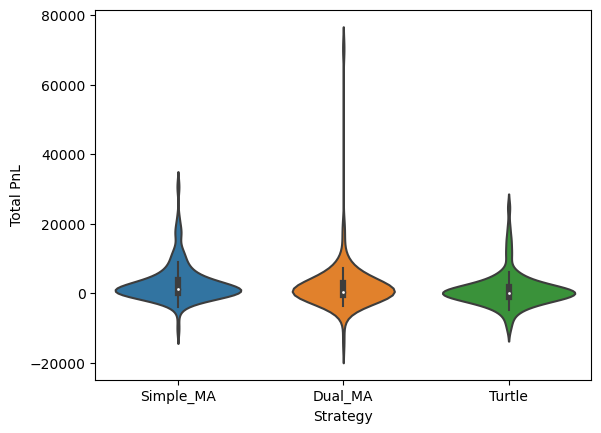

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.violinplot(x='Strategy', y='Total PnL', data=results_df)
plt.xlabel('Strategy')
plt.ylabel('Total PnL')
plt.savefig('Total PnL Distribution by Strategy', dpi=300, bbox_inches='tight')
plt.show()


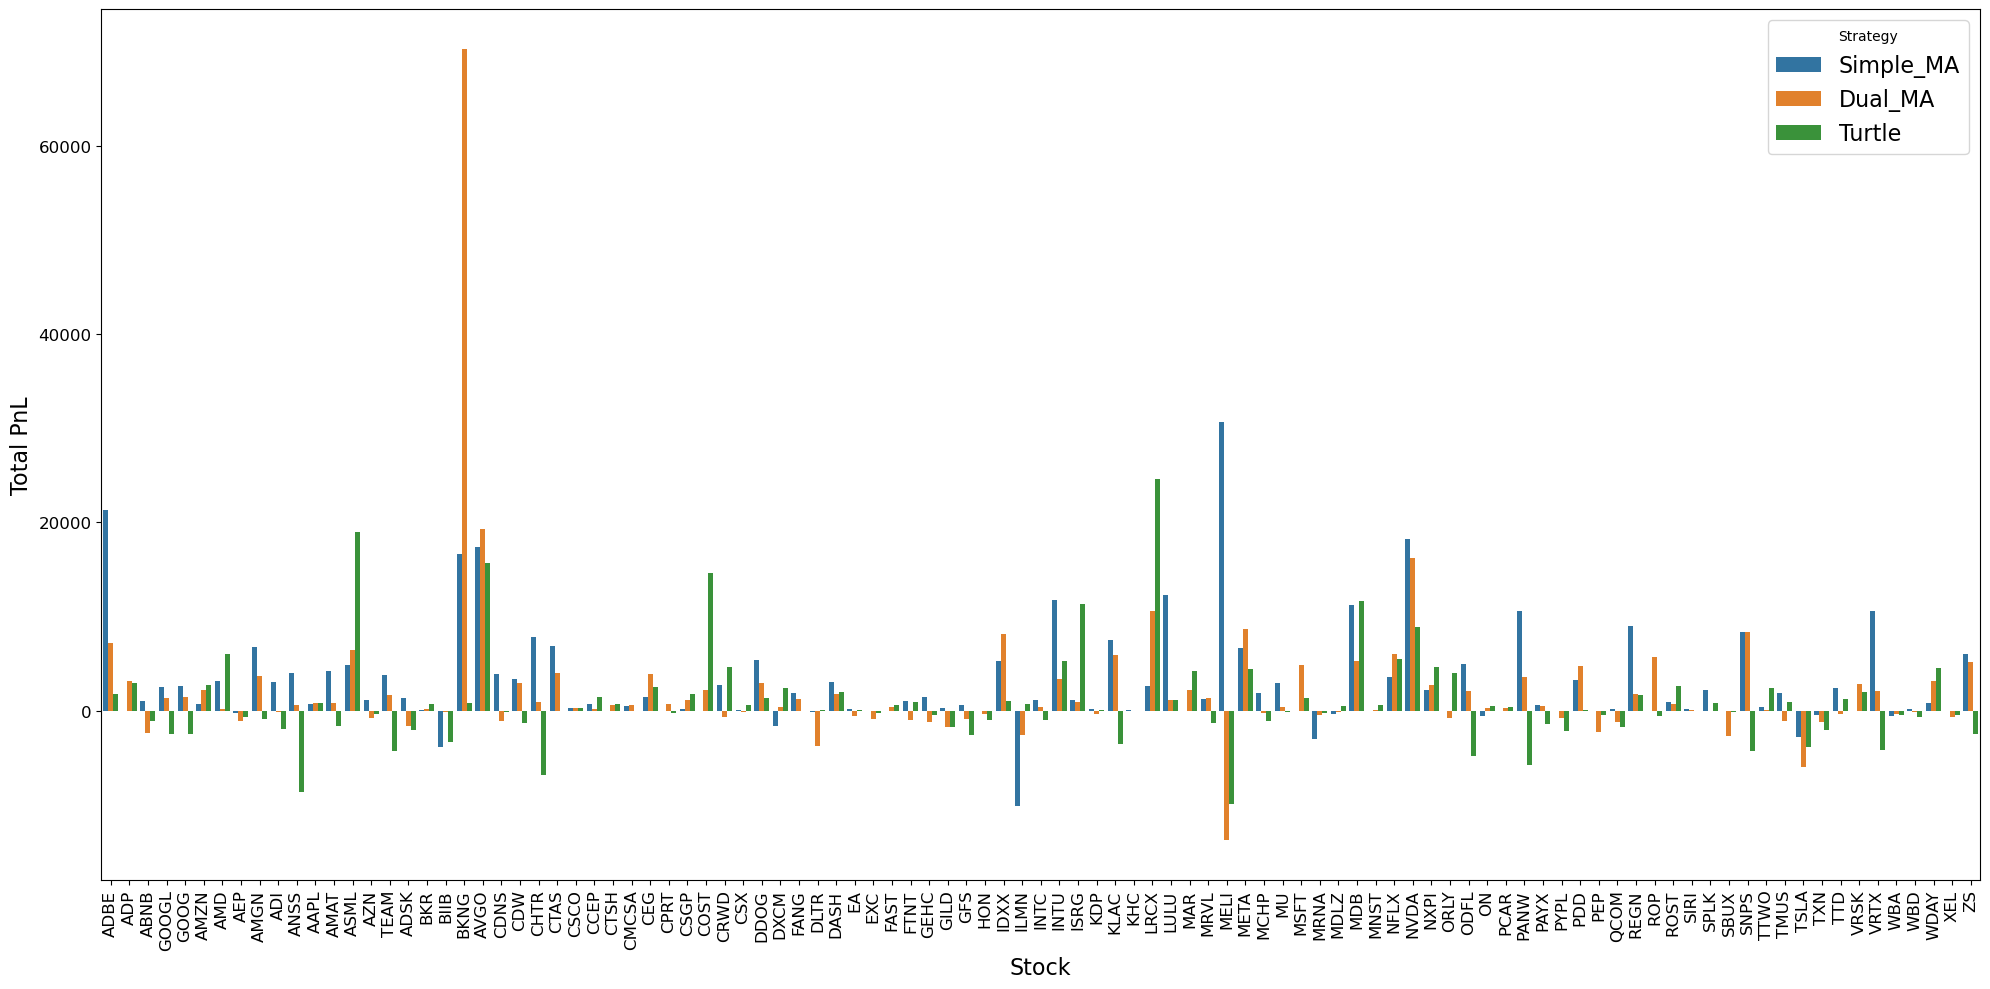

In [28]:
plt.figure(figsize=(20, 10))  # 根据需要调整宽度

sns.barplot(x='Stock', y='Total PnL', hue='Strategy', data=results_df)
plt.xlabel('Stock', fontsize=16)
plt.ylabel('Total PnL', fontsize=16)
plt.xticks(rotation=90, fontsize=12)  # 旋转x轴标签并设置字体大小
plt.yticks(fontsize=12)
plt.legend(title='Strategy', fontsize=16)

# 在保存和显示图像之前调整布局
plt.tight_layout()

# 保存图像
plt.savefig('Total_PnL_by_Stock_and_Strategy.png', dpi=300, bbox_inches='tight')

# 显示图像
plt.show()